(fft_dissipation)=
# Power spectrum of turbulent vertical velocity

Find the dissipation rate using an fft of tower vertical velocity data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


In [2]:
#load data sampled at 20.8333 Hz
tower_data = Path.home() / "Dropbox/phil_files/a500/notebooks"
tower_data = list(tower_data.glob("**/miam*npz"))[0]
print(tower_data)

/Users/phil/Dropbox/phil_files/a500/notebooks/miami_tower.npz


In [3]:
td=np.load(str(tower_data)) #load temp, uvel, vvel, wvel, minutes
print('keys: ',td.keys())
print(td['description'])

keys:  KeysView(NpzFile '/Users/phil/Dropbox/phil_files/a500/notebooks/miami_tower.npz' with keys: wvel, vvel, minutes, temp, __header__...)

These are measurements of atmospheric
turbulent velocity (wvel, uvel, vvel (m/s) and temperature (temp), taken
over a 30 minute period at a sampling rate of 20.8333 (125/6)
Hz. They were measured by a sonic anemometer at a height of 40 m over
suburban Miami during unstable conditions (12:01-12:31 LAT)

Total length of each timeseries is 37,500 values, so total sample time is
37000*(6/125) = 1800 seconds = 30 minutes



## Step 1: plot the raw spectrum and confirm the W-K theorem

check Wiener-Khichine theorem for wvel

raw fft sum, full time series:     1.0337

velocity variance:     1.0337

check:  1.033728613922596


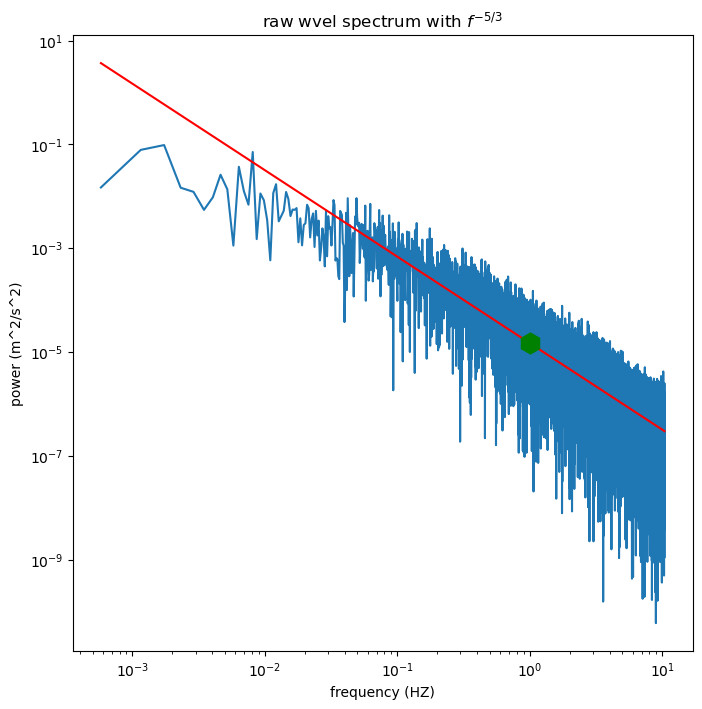

In [4]:
sampleRate=20.833
nyquistfreq=sampleRate/2.


totsize=36000
wvel=td['wvel'][0:totsize].flatten()
temp=td['temp'][0:totsize].flatten()
wvel = wvel - np.mean(wvel)
temp= temp - np.mean(temp)
flux=wvel*temp


halfpoint=int(np.floor(totsize/2.))
frequencies=np.arange(0,halfpoint)
frequencies=frequencies/halfpoint
frequencies=frequencies*nyquistfreq

# raw spectrum -- no windowing or averaging
#First confirm Parseval's theorem
# (Numerical Recipes 12.1.10, p. 498)

thefft=np.fft.fft(wvel)
power=np.real(thefft*np.conj(thefft))
print('check Wiener-Khichine theorem for wvel')
print('\nraw fft sum, full time series: %10.4f\n' % (np.sum(power)/totsize**2.))
print('velocity variance: %10.4f\n' % (np.sum(wvel*wvel)/totsize))


fig,theAx=plt.subplots(1,1,figsize=(8,8))
frequencies[0]=np.NaN
power[0]=np.NaN
power_half=2.*power[:halfpoint]/(totsize**2.)
print('check: ',np.nansum(power_half))
theAx.loglog(frequencies,power_half)
theAx.set_title('raw wvel spectrum with $f^{-5/3}$')
theAx.set(xlabel='frequency (HZ)',ylabel='power (m^2/s^2)')
#
# pick one point the line should pass through (by eye)
# note that y intercept will be at log10(freq)=0
# or freq=1 Hz
#
leftspec=np.log10(power_half[1]*1.e-3)
logy=leftspec - 5./3.*np.log10(frequencies)
yvals=10.**logy
theAx.loglog(frequencies,yvals,'r-')
thePoint=theAx.plot(1.,power_half[1]*1.e-3,'g+')
thePoint[0].set_markersize(15)
thePoint[0].set_marker('h')
thePoint[0].set_markerfacecolor('g')

## Step 2: check power spectrum layout

Here is what the entire power spectrum looks like, showing positive and negative frequencies

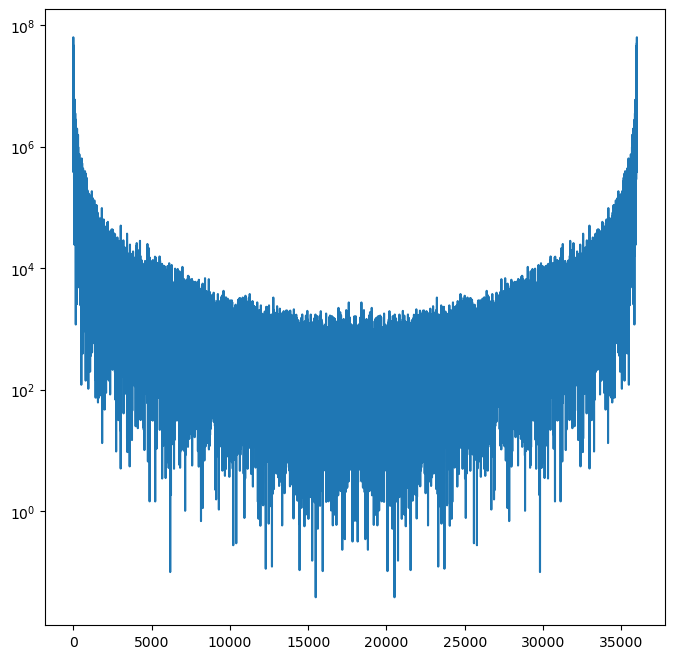

In [5]:
fig,theAx=plt.subplots(1,1,figsize=(8,8))
out=theAx.semilogy(power)

and here is what fftshift does:

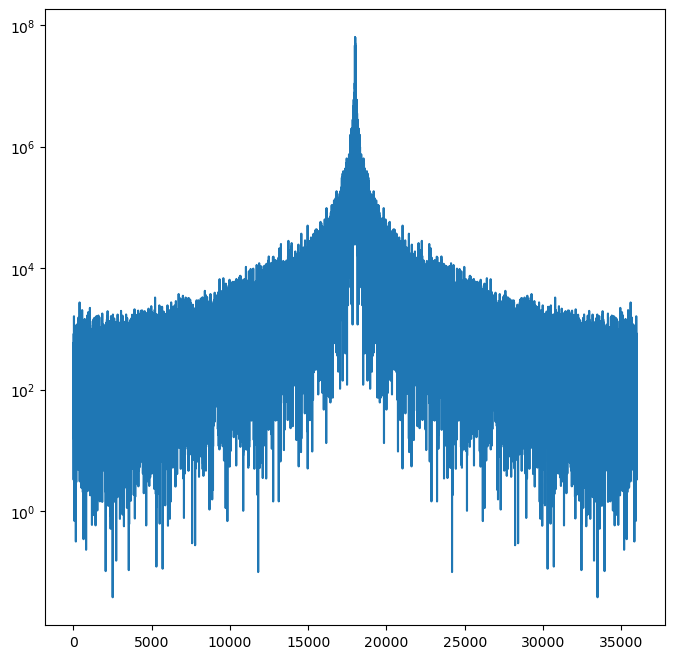

In [6]:
shift_power=np.fft.fftshift(power)
fig,theAx=plt.subplots(1,1,figsize=(8,8))
out=theAx.semilogy(shift_power)

### Confirm that the fft at negative f is the complex conjugate of the fft at positive f

(200.4277107839311-150.32508399544918j)
(200.42771078393093+150.32508399544923j)


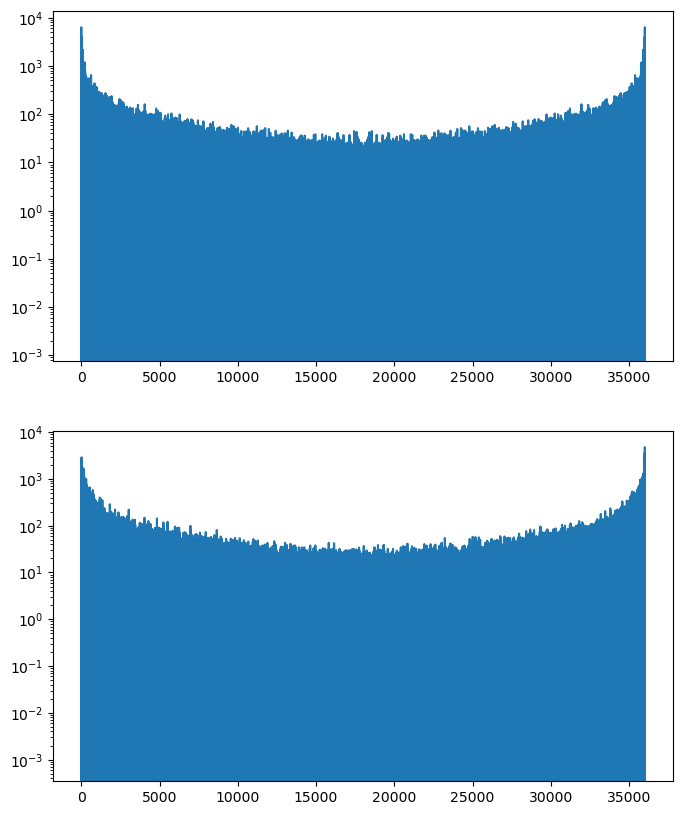

In [7]:
test_fft=np.fft.fft(wvel)
fig,theAx=plt.subplots(2,1,figsize=(8,10))
theAx[0].semilogy(np.real(test_fft))
theAx[1].semilogy(np.imag(test_fft))
print(test_fft[100])
print(test_fft[-100])

## Step 3: Windowing and averaging subsamples

The FFT above is noisy, and there are several ways to smooth it.  Numerical Recipes, p. 550 has a good discussion of "windowing" which helps remove the spurious power caused by the fact that the timeseries has a sudden stop and start.
Below we split the timeseries into 25 segements of 1440 points each, fft each segment then average the 25.  We convolve each segment with a Bartlett window.




Try a windowed spectrum (Bartlett window)

sumw:      0.533


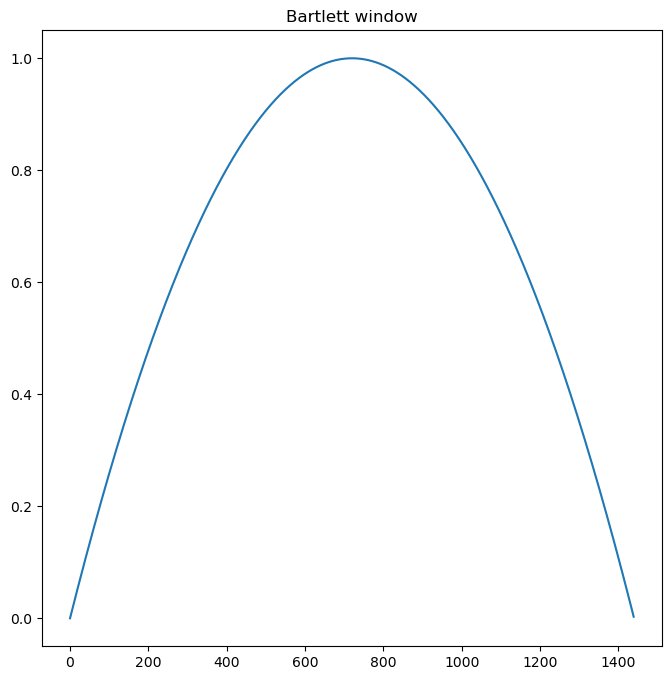

In [8]:
print('\n\n\nTry a windowed spectrum (Bartlett window)\n')
## windowing -- see p. Numerical recipes 550 for notation

def calc_window(numvals=1440):
    """
      Calculate a Bartlett window following
      Numerical Recipes 13.4.13
    """
    
    halfpoint=int(np.floor(numvals/2.))
    facm=halfpoint
    facp=1/facm

    window=np.empty([numvals],float)
    for j in np.arange(numvals):
        window[j]=(1.-((j - facm)*facp)**2.)
    return window

#
#  we need to normalize by the squared weights
#  (see the fortran code on Numerical recipes p. 550)
#
numvals=1440
window=calc_window(numvals=numvals)
#window[:]=1.
sumw=np.sum(window**2.)/numvals
fig,theAx=plt.subplots(1,1,figsize=(8,8))
theAx.plot(window)
theAx.set_title('Bartlett window')
print('sumw: %10.3f' % sumw)

## Caveat -- subsamples no longer have zero mean, so power gets placed in bin 0

### Solution -- change the amplitude of the averaged spectrum so it matches the total variance of the time series

Look for ```normalized_power``` in the cell below

In [9]:
def do_fft(the_series,window,ensemble=25,title='title',debug=False):
    variance = np.sum(the_series*the_series)/len(the_series)
    print('total variance: ',variance)
    numvals=len(window)
    sumw=np.sum(window**2.)/numvals
    subset=the_series.copy()
    subset=subset[:len(window)*ensemble]
    subset=np.reshape(subset,(ensemble,numvals))
    winspec=np.zeros([numvals],float)
#
#  note that for these indvidual ensemble members
#  subset[therow,:] does not have mean = 0
#  this means that the 0 frequency bin, power[0] will
#  not be zero.
#
    for therow in np.arange(ensemble):
        thedat=subset[therow,:] 
        #thedat = thedat - thedat.mean()
        thefft =np.fft.fft(thedat*window)
        power=thefft*np.conj(thefft)
        if debug:
            print('\nensemble member: {}'.format(therow))
            thesum=np.real(np.sum(power)/(sumw*numvals**2.))
            print('thesum: {:10.4f}'.format(float(thesum)))
            print('\nwindowed fft sum (m^2/s^2): {0:10.4f}\n'.format(float(thesum)))
            thevar=np.sum(thedat*thedat)/numvals
            print('velocity variance (m^2/s^2): {0:10.4f}\n\n'.format(thevar))
        winspec=winspec + power

    winspec=np.real(winspec/(numvals**2.*ensemble*sumw))
    smoothed_variance=np.sum(winspec)
    print('total zero frequency component is: ',winspec[0])
    print('total smoothed power specturm is: ',np.sum(winspec))
    print('total measured variance is: ',variance)
    halfpoint=int(len(winspec)/2.)
    print('halfpoint is: ',halfpoint)
    print('left half: ',2.*np.sum(winspec[1:halfpoint]))
    print('right half:',2.*np.sum(winspec[halfpoint:]))
    #
    # force the returned spectrum to have 0 power in bin 0
    # and total variance = observed variance
    #
    normalized_power=np.empty_like(winspec)
    normalized_power[1:]=winspec[1:]/np.sum(winspec[1:])*variance
    normalized_power[0]=0.
    print('normalized power spectrum has variance ',np.sum(normalized_power))
    return normalized_power

## Try running do_fft with and without debug printing

In [10]:
winspec=do_fft(wvel,window,debug=True)

total variance:  1.0337289478524807

ensemble member: 0
thesum:     0.5232

windowed fft sum (m^2/s^2):     0.5232

velocity variance (m^2/s^2):     0.4487



ensemble member: 1
thesum:     0.2931

windowed fft sum (m^2/s^2):     0.2931

velocity variance (m^2/s^2):     0.2864



ensemble member: 2
thesum:     1.3525

windowed fft sum (m^2/s^2):     1.3525

velocity variance (m^2/s^2):     1.2092



ensemble member: 3
thesum:     0.6944

windowed fft sum (m^2/s^2):     0.6944

velocity variance (m^2/s^2):     0.8238



ensemble member: 4
thesum:     0.9625

windowed fft sum (m^2/s^2):     0.9625

velocity variance (m^2/s^2):     1.0749



ensemble member: 5
thesum:     0.5613

windowed fft sum (m^2/s^2):     0.5613

velocity variance (m^2/s^2):     0.6567



ensemble member: 6
thesum:     1.2611

windowed fft sum (m^2/s^2):     1.2611

velocity variance (m^2/s^2):     1.0692



ensemble member: 7
thesum:     1.2332

windowed fft sum (m^2/s^2):     1.2332

velocity variance (m^2/s^2):  

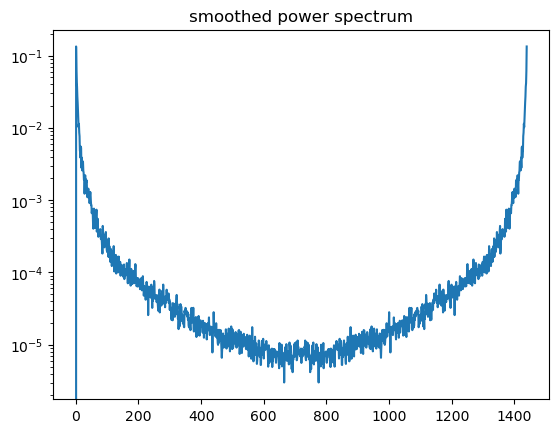

In [11]:
%matplotlib inline
fig,ax=plt.subplots(1,1)
ax.semilogy(winspec)
out=ax.set(title='smoothed power spectrum')

## We want the integral over the positive frequencies to give the total variance, so increase spectral values by 2x

In addition, we want $E(k)$ to have spectral densities units of $W\,m^{-2}\,Hz^{-1}$, so that this integral works:

$$\int_0^\infty E(k) dk = \sigma^2_w$$

That means we need to divide by the frequency bin width $\Delta f$

In [12]:
sampleRate=20.833
nyquistfreq=sampleRate/2.
halfpoint=int(len(winspec)/2.)
averaged_freq=np.linspace(0,1.,halfpoint)*nyquistfreq   
winspec_half=2.*winspec[1:halfpoint]
print('summed power spectrum: ',np.sum(winspec_half))
delta_f=np.diff(averaged_freq)[0]
power_dens=winspec_half/delta_f
averaged_freq=averaged_freq[1:]

summed power spectrum:  1.0337233465757985


## Step 4: fit the averaged spectrum to $E(f) = A_0 f^{-5/3}$ on a loglog plot

In [13]:
from scipy.optimize import curve_fit

def fit_func(log10_f, log10_A):
    'fit A*f^{-5/3} for log/log plot'
    fit = log10_A - 5./3.*log10_f
    return fit

initial_A=0.
log10_A, pcov = curve_fit(fit_func,np.log10(averaged_freq),np.log10(power_dens), 
                       p0=initial_A)

Value of constant Ai =  0.04997
how good is the fit at point 100? spectrum:  0.02649  -5/3:  0.02880


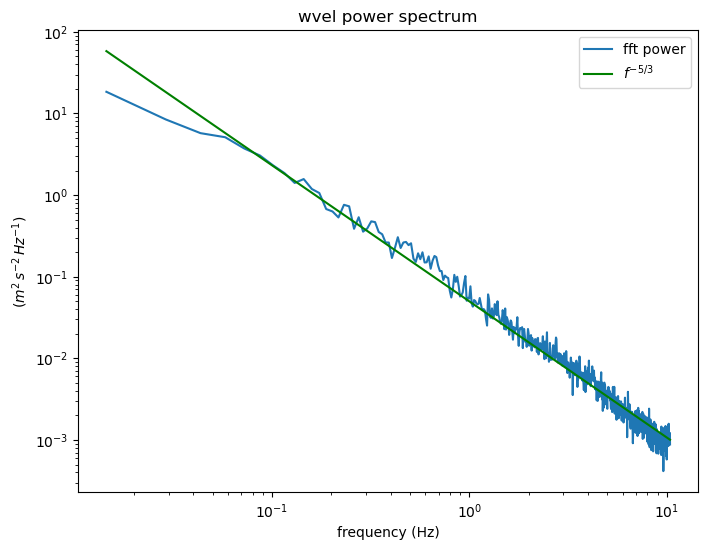

In [14]:
def do_plot(the_freq,the_spec,log10_A=1,slope= -5./3.,title=None,ylabel=None):
    fig,theAx=plt.subplots(1,1,figsize=(8,6))
    theAx.loglog(the_freq,the_spec,label='fft power')
    if title:
        theAx.set_title(title)
    logy = log10_A + slope*np.log10(the_freq)
    yvals=10.**logy
    theAx.loglog(the_freq,yvals,'g-',label='$f^{-5/3}$')
    theAx.set_xlabel('frequency (Hz)')
    if ylabel:
        out=theAx.set_ylabel(ylabel)
    out=theAx.legend(loc='best')
    return theAx

params=dict(log10_A=log10_A[0],title='wvel power spectrum',
            ylabel='$(m^2\,s^{-2}\,Hz^{-1})$')
ax=do_plot(averaged_freq,power_dens,**params)
fit=10**log10_A[0]*averaged_freq[100]**(-5./3.)
check=power_dens[100]
print('Value of constant Ai = {:8.5f}'.format(10**log10_A[0]))
print('how good is the fit at point 100? spectrum: {:8.5f}  -5/3: {:8.5f}'.format(fit,check))

## Step 5: Use Kolmogorov 1941 to find $\epsilon$

According to [McBean and Elliot (1975)](http://ezproxy.library.ubc.ca/login?url=http://journals.ametsoc.org/doi/abs/10.1175/1520-0469%281975%29032%3C0753%3ATVTOKE%3E2.0.CO%3B2) or Stull page 431, we want to solve this equation:

$$E(k) = A_0 k^{-5/3} = 0.5 \epsilon^{2/3} k^{-5/3}$$  for $\epsilon$ at some value of k.

$$\epsilon = 0.5 E(k)^{3/2} k^{5/2}$$

for all $k$ in the inertial subrange.

If the turbulence is frozen, then we can convert from $f$ to $k$ with the mean windspeed $\overline{U}$ (Stull eq. 1.4c)

$$f = \overline{U} k$$

$$df = \overline{U} dk$$

So for the change of variables we need to make sure that:

$$E(f)df  = E(k)dk$$  (i.e. the power in a bin stays the same).

$$E(f) df = A_0 f^{-5/3} df = A_0 (\overline{U} k)^{-5/3} \overline{U} dk = A_0 \overline{U}^{-2/3} k^{-5/3} dk$$

From our fit:

$$E(f) = 0.055 f^{-5/3} = 0.055 (\overline{U} k)^{-5/3}$$

and taking $\overline{U} = 10\ m/s$ as a typical value for Miami:

$$E(k) = (0.055) 10^{-2/3} k^{-5/3}  = (0.055)(0.2) k^{-5./3.} = 0.01 k^{-5/3}$$

Evaluate this at f= 1 Hz which corresponds to k = 1 Hz/(10 m/s) = 0.1 $m^{-1}$: 

$$E(0.1) = 0.01 \times 0.1^{-5/3}  = 0.46\ m^2\,s^{-2}/m^{-1} = 0.46\ m^3\,s^{-2}$$

So using the formula:

\begin{align}
\epsilon &= 0.5 E(k)^{3/2} k^{5/2} = 0.5(0.46)^{3/2}(0.1)^{5/2} = 5 \times 10^{-4}\ m^2 s^{-3}
\end{align}

### Is this ε a reasonable value for the vertical turbulent dissipation rate?

1. Suppose the turbulence is isotropic, so the u and v components have the same $\epsilon$.  Then the total     dissipation rate is $1.5 \times 10^{-3}\ m^2 s^{-3}$.  If the total variance in the windfiled was $3\ m^2\,s^{-2}$, then that would imply that the atmosphere would "spin down" in 3/1.5e-3 = 2000 seconds = 33 minutes.

2. Also check out Figure 10 of [Campistron et al., 2002](http://dx.doi.org/10.1023/A%3A1014985111855)

## Does the data support f^{-5/3}?

Try fitting again, but this time let the slope be a free parameter.  Do we get -5/3?

In [15]:
def fit_func(log10_f, log10_A, slope):
    'fit A*f^{-5/3} for log/log plot'
    fit = log10_A + slope*log10_f
    return fit

initial_A=0.
coeffs, pcov = curve_fit(fit_func,np.log10(averaged_freq),np.log10(power_dens), 
                       p0=[initial_A,-2.])
print('log10_A and slope: {:8.5f} {:8.5f} instead of -1.6666'.format(*coeffs))

log10_A and slope: -1.25646 -1.74325 instead of -1.6666


Value of constant A0 =  0.04997
how good is the fit at point 100? spectrum:  0.02853  -5/3:  0.02880


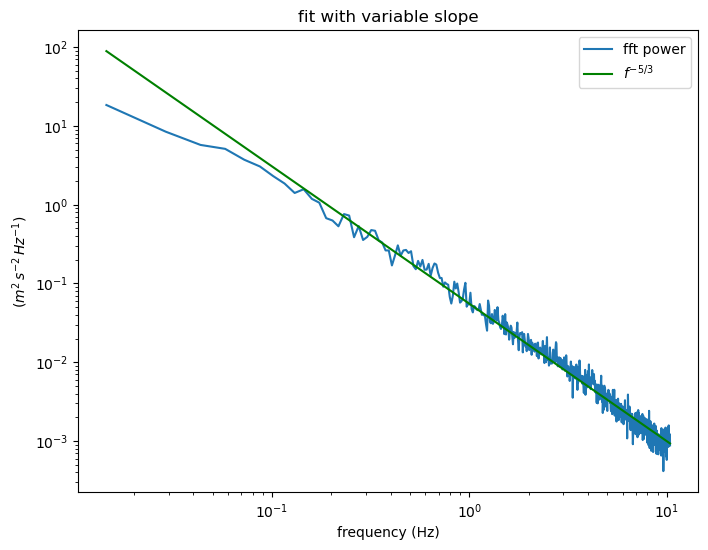

In [16]:
params['title']='fit with variable slope'
params['log10_A']=coeffs[0]
params['slope']=coeffs[1]
ax=do_plot(averaged_freq,power_dens,**params)
fit=10**coeffs[0]*averaged_freq[100]**coeffs[1]
check=power_dens[100]
print('Value of constant A0 = {:8.5f}'.format(10**log10_A[0]))
print('how good is the fit at point 100? spectrum: {:8.5f}  -5/3: {:8.5f}'.format(fit,check))

### Smothing the power spectrum by simple binning

Instead of the elaborate subsetting and windowing we did above, what if we just dropped the power spectrum values into a coarser set of frequency bins?  Would that change the results?

log10_A and slope: -1.43033 -1.71714 instead of -1.6666


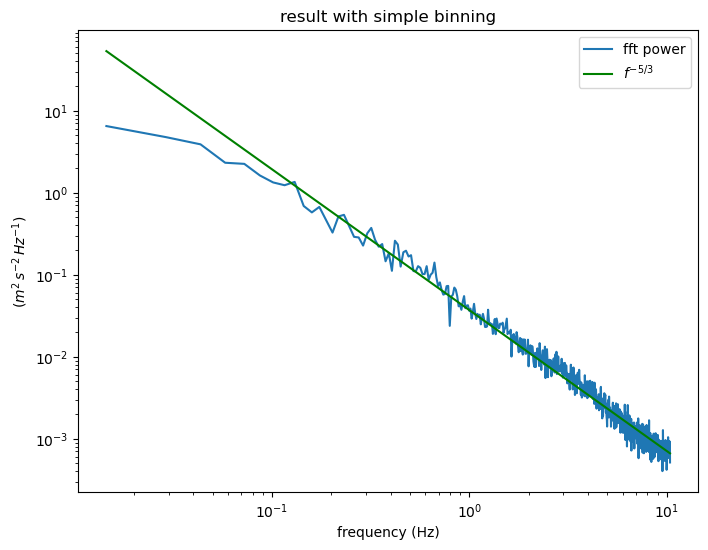

In [17]:
new_spec=power_half.reshape((720,-1))
new_dens=new_spec[1:].sum(axis=1)/delta_f


coeffs, pcov = curve_fit(fit_func,np.log10(averaged_freq),np.log10(new_dens), 
                       p0=[initial_A,-2.])
params['log10_A']=coeffs[0]
params['slope']=coeffs[1]
print('log10_A and slope: {:8.5f} {:8.5f} instead of -1.6666'.format(*coeffs))

ax=do_plot(averaged_freq,new_dens,**params)
out=ax.set_title('result with simple binning')